# Imports, setup etc.

In [1]:
# System
import os
import time

# Standard libs
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt

# Image utils
from PIL import Image

# PyTorch 
import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader

In [2]:
!pip -q install httpimport
import httpimport

In [3]:
DATA_PATH = '/kaggle/input/gtsrb-german-traffic-sign'
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'Train')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'Test')

# Playground

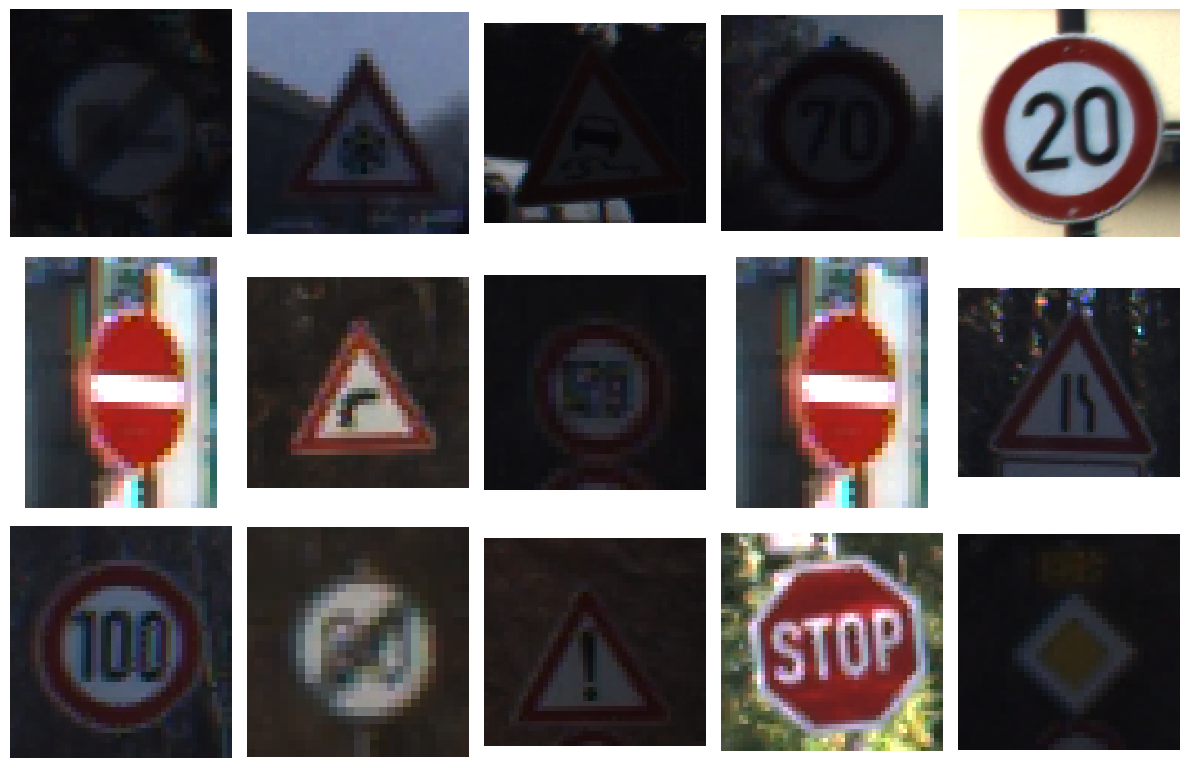

In [4]:
# file_names = os.listdir(folder_path)
# file_names = file_names[:15]

n_classes = 15
folder_names = [os.path.join(TRAIN_DATA_PATH, str(i)) for i in random.choices(range(43), k=n_classes)]
file_names = [os.path.join(fldr, os.listdir(fldr)[0]) for fldr in folder_names]

num_images = len(file_names)
num_rows = 3  
num_cols = 5  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i, image_path in enumerate(file_names):
    image = Image.open(image_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Data load

In [5]:
train_meta_data = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test_meta_data = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
print(f"Train images: {train_meta_data.shape[0]} | Test images: {test_meta_data.shape[0]}")

Train images: 39209 | Test images: 12630


In [6]:
print(f"Number of training images for each class:")
# print(100 * "-")
(
    train_meta_data.groupby("ClassId")
    .agg({"Path": "count"})
    .sort_values("ClassId")
    .transpose()
)

Number of training images for each class:


ClassId,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
Path,210,2220,2250,1410,1980,1860,420,1440,1410,1470,...,689,420,1200,390,210,2070,300,360,240,240


In [7]:
"""
"""
print(f"Number of test images for each class:")
# print(100 * "-")
(
    test_meta_data.groupby("ClassId")
    .agg({"Path": "count"})
    .sort_values("ClassId")
    .transpose()
)

Number of test images for each class:


ClassId,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
Path,60,720,750,450,660,630,150,450,450,480,...,210,120,390,120,60,690,90,90,60,90


In [8]:
print(f"Training images sizes:")
(
    train_meta_data
    .agg({"Width": ["min", "median", "max"], "Height": ["min", "median", "max"]})
    .transpose()
)

Training images sizes:


,min,median,max
Width,25.0,43.0,243.0
Height,25.0,43.0,225.0


array([[<AxesSubplot: title={'center': 'Width'}>,
        <AxesSubplot: title={'center': 'Height'}>]], dtype=object)

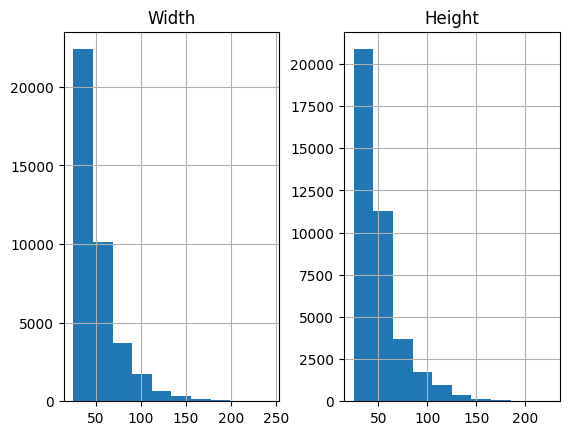

In [9]:
(
    train_meta_data[["Width", "Height"]]
    .hist()
)

## Transforms, data augmentation

In [10]:
class TestImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, "Path"])
        image = read_image(img_path)
#         image = image.permute(1, 2, 0).numpy()
        to_pil = transforms.ToPILImage()
        image = to_pil(image)
        label = self.img_labels.loc[idx, "ClassId"]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
class ResizeAndPad:
    def __init__(self, size, fill=0, padding_mode='constant'):
        self.size = size
        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, img):
        aspect_ratio = img.width / img.height
        if img.width < img.height:
            new_width = self.size
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = self.size
            new_width = int(new_height * aspect_ratio)
        resized_img = img.resize((new_width, new_height))

        left = (self.size - new_width) // 2
        top = (self.size - new_height) // 2
        right = self.size - new_width - left
        bottom = self.size - new_height - top

        padded_img = transforms.functional.pad(resized_img, (left, top, right, bottom), fill=self.fill, padding_mode=self.padding_mode)
        return padded_img

In [12]:
re_size = 32

train_transform = transforms.Compose([
    ResizeAndPad(re_size),
    transforms.ColorJitter(brightness=[0.5,1.5], contrast=[0.5,1.5]),
    transforms.RandomPerspective(0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


valid_transform = transforms.Compose([
    ResizeAndPad(re_size),
    #transforms.ColorJitter(contrast=[20,30], brightness=[20,30]),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


test_transform = transforms.Compose([
    ResizeAndPad(re_size),
    #transforms.ColorJitter(contrast=[2,3], brightness=[2,3]),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])



transforms_dict = {"train": train_transform, "valid": valid_transform, "test": test_transform}

## Create datasets and loaders

In [13]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self


In [14]:
def create_data_loaders(data_transforms, data_path=DATA_PATH, train_size=0.8, batch_size=64):
    
    train_transform, valid_transform, test_transform = data_transforms["train"], data_transforms["valid"], data_transforms["test"]
    # Create datasets
    full_train_dataset = datasets.ImageFolder(os.path.join(DATA_PATH, 'Train'))
    full_train_dataset.target_transform = lambda id: int(full_train_dataset.classes[id])
    # Define the length of train and valid sets
    train_size = int(train_size * len(full_train_dataset))
    valid_size = len(full_train_dataset) - train_size
    # Define indices of train and valid sets
    indices = torch.randperm(len(full_train_dataset)).tolist()
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:]

    # Create train, valid test sets
    train_dataset = Subset(full_train_dataset, train_indices)
    valid_dataset = Subset(full_train_dataset, valid_indices)
    test_dataset = TestImageDataset(DATA_PATH, os.path.join(DATA_PATH, 'Test.csv'), transform=test_transform)

    # Apply transformations
    train_dataset.dataset.transform = train_transform
    valid_dataset.dataset.transform = valid_transform

    # Create dataloaders
    loaders = {}
    loaders["train"] = InMemDataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    loaders["valid"] = InMemDataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    loaders["test"] = InMemDataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return loaders


In [15]:
loaders = create_data_loaders(transforms_dict)

  0%|          | 0/31367 [00:00<?, ?it/s]

/tmp/ipykernel_32/1644944299.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = [torch.tensor(t) for t in dataset[i]]


  0%|          | 0/7842 [00:00<?, ?it/s]

  0%|          | 0/12630 [00:00<?, ?it/s]

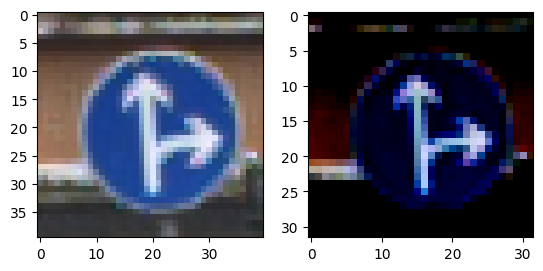

In [16]:
re_size = 32
# Define transforms 
train_transform = transforms.Compose([
    ResizeAndPad(re_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

image = Image.open('/kaggle/input/gtsrb-german-traffic-sign/Train/36/00036_00011_00014.png')
image_trans = train_transform(image).permute(1, 2, 0).numpy()
f, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(image_trans)

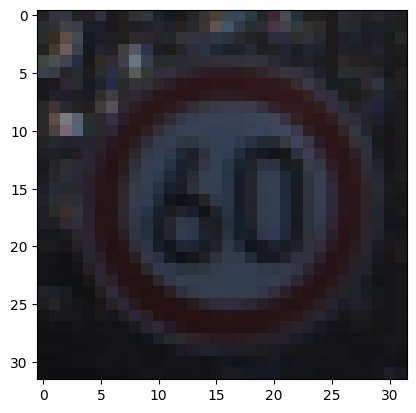

In [17]:
next(iter(loaders["valid"]))[0][0]
plt.imshow(next(iter(loaders["valid"]))[0][0].permute(1,2,0).cpu().numpy())



In [18]:
# mean = 0.0
# for images, _ in loaders["train"]:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
# mean = mean / len(loaders["train"])

# First model

In [25]:
def SGD(
    model,
    data_loaders,
    alpha=1e-4,
    epsilon=0.0,
    decay=0.0,
    num_epochs=1,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    device="cpu",
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)
    velocities = [None for _ in model.parameters()]
    
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            for x, y in data_loaders["train"]:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(), velocities):
                        p -= alpha * p.grad

                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, data_loaders["valid"], device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs | best so far {3: >5.4f}%".format(
                epoch, val_err_rate * 100.0, num_epochs, best_val_err * 100.0,
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

In [26]:
def compute_error_rate(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)

    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples


def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()


-----------------------------------------------------------------------------------
After epoch 2015 | valid err rate:  0.24% | doing 2015 epochs | best so far 0.1658%
-----------------------------------------------------------------------------------

Loading best params on validation set (epoch 1343)

---------------------------------------------
Test error rate: 3.009%, training took 2888s.
---------------------------------------------


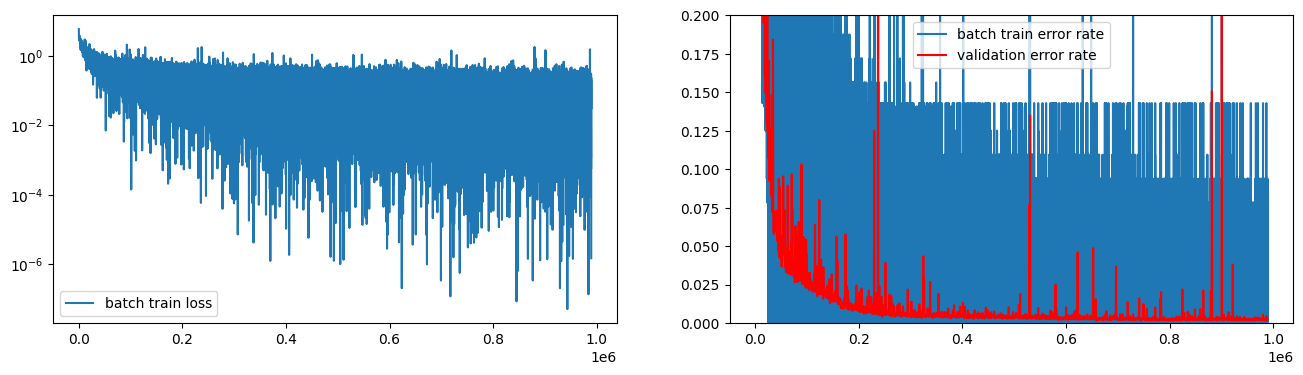

In [35]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


model = Model(nn.Linear(3 * 32 * 32, 43))

model = Model(
    nn.Unflatten(1, (3, 32, 32)),
    nn.Conv2d(3, 8, kernel_size=5, padding="same"),
    nn.Dropout(0.2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=5, padding="same"),
    nn.Dropout(0.2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=5, padding="same"),
    nn.Dropout(0.2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(512, 200),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(200, 43),
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            p.normal_(0, 0.1)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, loaders, alpha=1e-2, max_num_epochs=3000, device="cuda", log_every = 250)


test_err_rate = compute_error_rate(model, loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

In [36]:
def get_mistakes(model, data_loader, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)
    num_errs = 0.0
    num_examples = 0
    wrong_imgs = []
    wrong_labels = []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            wrong_imgs.append(x[predictions != y.data])
            wrong_labels.append(predictions[predictions != y.data])
    return wrong_imgs, wrong_labels

In [37]:
wrong_imgs, wrong_labels = get_mistakes(model, loaders["test"])
wrong_labels = torch.cat(wrong_labels)
wrong_imgs = torch.cat(wrong_imgs)
mistakes = wrong_imgs.size()[0]

meta_imgs=[]

for i in range(43):
    img = Image.open(DATA_PATH+"/Meta/"+str(i)+".png")
    meta_imgs.append(img)

Showing 100 mistakes out of 380:


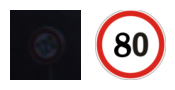

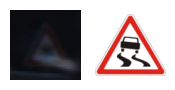

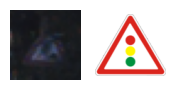

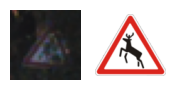

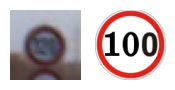

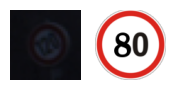

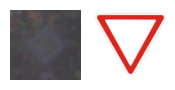

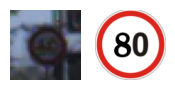

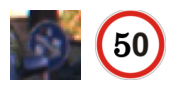

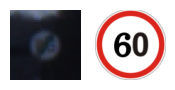

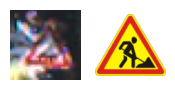

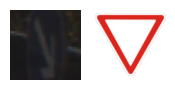

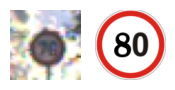

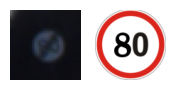

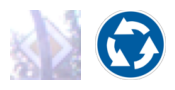

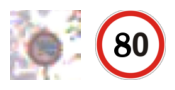

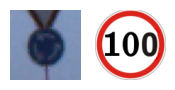

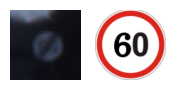

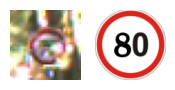

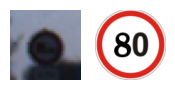

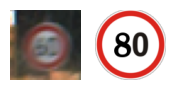

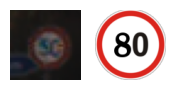

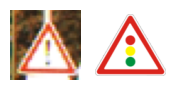

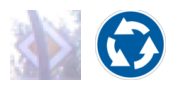

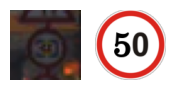

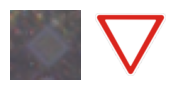

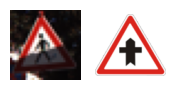

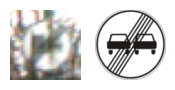

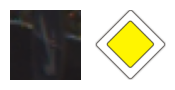

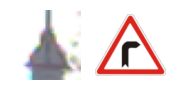

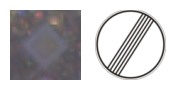

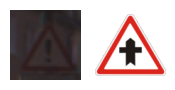

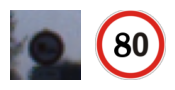

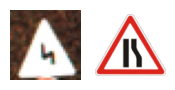

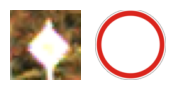

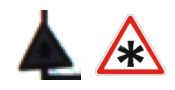

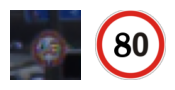

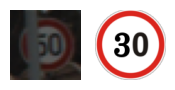

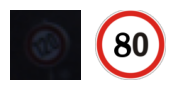

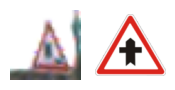

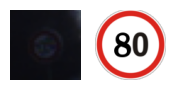

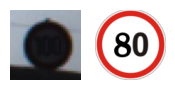

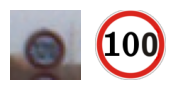

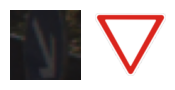

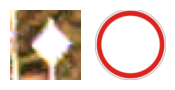

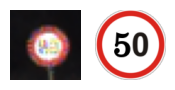

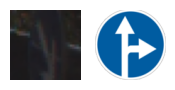

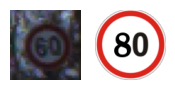

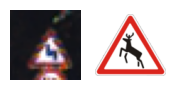

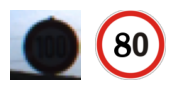

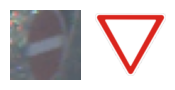

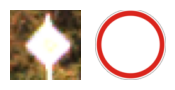

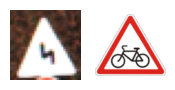

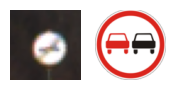

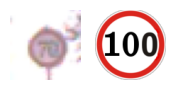

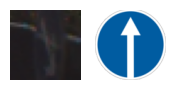

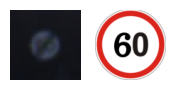

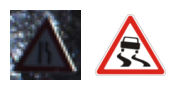

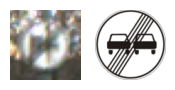

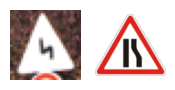

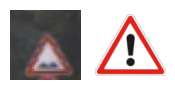

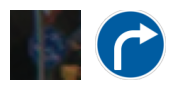

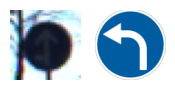

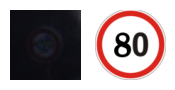

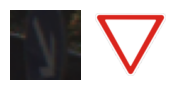

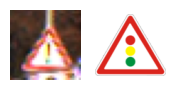

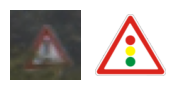

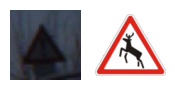

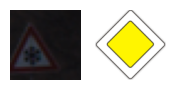

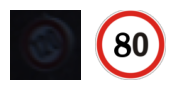

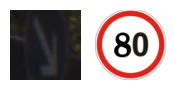

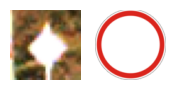

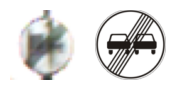

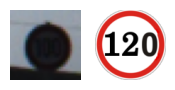

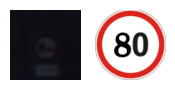

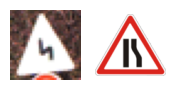

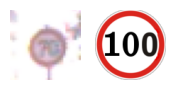

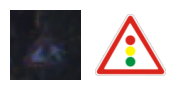

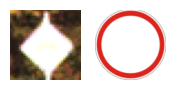

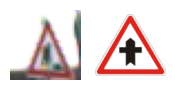

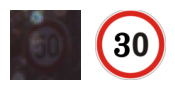

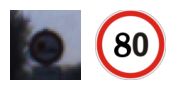

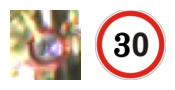

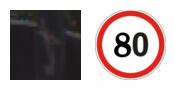

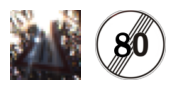

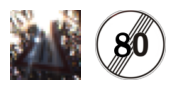

In [ ]:
shown_mistakes =  min(mistakes, 100)
to_print = f"Showing {shown_mistakes} mistakes"
if mistakes>shown_mistakes:
    to_print = to_print + f" out of {mistakes}"
to_print += ":"
print(to_print)


for i in range( shown_mistakes ):
    fig = plt.figure(figsize=(2,2))
    plt.subplot(1,2,1)
    
    plt.imshow(wrong_imgs[i].permute(1,2,0))
    
    plt.axis("off")
    plt.subplot(1,2,2)
    
    v = plt.imshow(meta_imgs[wrong_labels[i]])   
    
    plt.axis("off")
    plt.show()